## Introduction

Our main goal will be to group these clients in customer segments by using a clustering technique. Here, we’ll be using K-Means. However, how to group these clients? Which variables to use? We can try to analyse the customers by using the RFM (recency, frequency, monetary value) approach - this method is used to evaluate customer value.

The data is obtained form UCI can be downloaded from [here](https://archive.ics.uci.edu/ml/datasets/Online+Retail). 

This data set is composed of 8 attributes and 541.909 instances showing all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based online retail. According to UCI, the company mainly sells unique all-occasion gifts and many customers of the company are wholesalers.

# Import Libraries and Data

In [80]:
# Import libraries
import pandas as pd
import datetime as dt
import numpy as np
import re

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import collections
from collections import Counter
from collections import defaultdict
import itertools

import html5lib
import lxml


from scipy import stats
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


**Attribute Information**
- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
<br><br>
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
<br><br>
- Description: Product (item) name. Nominal.
<br><br>
- Quantity: The quantities of each product (item) per transaction. Numeric.
<br><br>
- InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction was generated.
<br><br>
- UnitPrice: Unit price. Numeric, Product price per unit in sterling.
<br><br>
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
<br><br>
- Country: Country name. Nominal, the name of the country where each customer resides.

In [3]:
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [4]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


**Initial Findings**
- **Potential data reversal**. 
    - The max and min value of Quantity are both 80995; it could represent a reversal of data entry. However, the issue is that both the initial and reversal entry are retained in the dataset. Further investigation is needed to understand the nature and determine the best way to manage such data reversal.
- **Potential indication of cancellation orders from negative UnitPrice**. 
    - It is uncommon to have negative UnitPrice, as this would mean a cash outflow to a company. These transactions could represent cancelled orders by customers or bad-debt/write-off incurred by the business.
- **Missing 25% of CustomerID**. 
    - The missing unique identified of customers could post a problem as market/customer segmentation requires grouping each unique customer into a group.

# Data Pre-Processing and Feature Engineering

## InvoiceDate

**Separate Date and Time information from InvoiceDate**
- The InvoiceDate column contains both date and time of the transaction. These data are separated into individual columns to facilitate future feature engineering and data manipulation.

In [6]:
# Split datetime from InvoiceDate
df['Date'] = df['InvoiceDate'].dt.date
df['Time'] = df['InvoiceDate'].dt.time

# Remove InvoiceDate column
df.drop(['InvoiceDate'], axis=1, inplace=True)

df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00


## InvoiceNo

**Extract transaction status from InvoiceNo**
- InvoiceNo contains both transaction status (i.e. having a 'C' denotes cancelled transaction) and transaction identifier (e.g. unique invoice number). This information could be extracted to facilitate further feature engineering.

In [7]:
# Separate order status and invoice number from InvoiceNo
df['CancelledOrder'] = df['InvoiceNo'].apply(
    lambda x: re.findall(r'[A-Z]', str(x))).apply(lambda x: pd.Series(x))
df['Invoice_No'] = df['InvoiceNo'].apply(
    lambda x: re.findall(r'\d+', str(x))).apply(lambda x: pd.Series(x))

# Remove old InvoiceNo column
df.drop(['InvoiceNo'], axis=1, inplace=True)

df.head()

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,NaN,536365
1,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,NaN,536365
2,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,NaN,536365
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,NaN,536365
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,NaN,536365


In [8]:
# Encode CancelledOrder
df['CancelledOrder'] = df['CancelledOrder'].astype('category')
df['CancelledOrder'].unique()

[NaN, C, A]
Categories (2, object): [C, A]

In [9]:
def filter_row(df, column, criterion, operator='equal'):
    '''
    Filter rows based on specific condition
    '''
    if operator == 'equal':
        return df[df[column] == criterion]
    if operator == 'less':
        return df[df[column] <= criterion]
    if operator == 'more':
        return df[df[column] >= criterion]

def remove_row(df, column, criterion):
    '''
    Remove ros based on specific condition
    '''
    return df[df[column] != criterion]

In [10]:
# 'A' category is unexpected; printing out rows to investigate further
filter_row(df, 'CancelledOrder', 'A')

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No
299982,B,Adjust bad debt,1,11062.06,NaN,United Kingdom,2011-08-12,14:50:00,A,563185
299983,B,Adjust bad debt,1,-11062.06,NaN,United Kingdom,2011-08-12,14:51:00,A,563186
299984,B,Adjust bad debt,1,-11062.06,NaN,United Kingdom,2011-08-12,14:52:00,A,563187


**Drop Bad Debt Records**

- Bad debt adjustments are dropped from the dataset as these do not represent actual sales. Furthermore, they are not tagged to any specific customer.

In [11]:
# Drop Bad Debt Record
df = remove_row(df, 'CancelledOrder', 'A')

# Encode column
df['CancelledOrder'] = df['CancelledOrder'].cat.add_categories([0])
df['CancelledOrder'].fillna(value=0, inplace=True)
df['CancelledOrder'].replace(to_replace='C', value=1, inplace=True)

df.head()

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365
1,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365
2,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365


## StockCode

In [12]:
df.nunique()

StockCode          4069
Description        4222
Quantity            722
UnitPrice          1628
CustomerID         4372
Country              38
Date                305
Time                774
CancelledOrder        2
Invoice_No        25897
dtype: int64

**StockCode as Categorical Data**
- StockCode is a unique identifier assigned to each item and the StockCode should be a category dtype. 
- Given the number of items, performing One Hot Encoding might not be feasible as this might result in 'curse of dimensionality'. This column will be one-hot encoded at a later stage should the need arise.

In [13]:
df['StockCode'] = df.StockCode.astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541906 entries, 0 to 541908
Data columns (total 10 columns):
StockCode         541906 non-null category
Description       540452 non-null object
Quantity          541906 non-null int64
UnitPrice         541906 non-null float64
CustomerID        406829 non-null float64
Country           541906 non-null object
Date              541906 non-null object
Time              541906 non-null object
CancelledOrder    541906 non-null int64
Invoice_No        541906 non-null object
dtypes: category(1), float64(2), int64(2), object(5)
memory usage: 42.6+ MB


## Unit Price

**Total spending of customers could be derived for additional datapoint**
- The unit price represents the price of a single item; a new column ('TotalSum') could be created to represent the total price paid by the customer for the respective purchase.

In [14]:
df['TotalSum'] = df['Quantity'] * df['UnitPrice']
df.describe()

,Quantity,UnitPrice,CustomerID,CancelledOrder,TotalSum
count,541906.000000,541906.000000,406829.000000,541906.000000,541906.000000
mean,9.552297,4.631552,15287.690570,0.017140,18.008308
std,218.081761,93.192775,1713.600303,0.129791,377.915677
min,-80995.000000,0.000000,12346.000000,0.000000,-168469.600000
25%,1.000000,1.250000,13953.000000,0.000000,3.400000
50%,3.000000,2.080000,15152.000000,0.000000,9.750000
75%,10.000000,4.130000,16791.000000,0.000000,17.400000
max,80995.000000,38970.000000,18287.000000,1.000000,168469.600000


In [15]:
# View rows with 0 TotalSum
filter_row(df, 'TotalSum', 0).head()

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum
622,22139,NaN,56,0.0,NaN,United Kingdom,2010-12-01,11:52:00,0,536414,0.0
1970,21134,NaN,1,0.0,NaN,United Kingdom,2010-12-01,14:32:00,0,536545,0.0
1971,22145,NaN,1,0.0,NaN,United Kingdom,2010-12-01,14:33:00,0,536546,0.0
1972,37509,NaN,1,0.0,NaN,United Kingdom,2010-12-01,14:33:00,0,536547,0.0
1987,85226A,NaN,1,0.0,NaN,United Kingdom,2010-12-01,14:34:00,0,536549,0.0


**Removing rows with 0 TotalSum**
- **(DISCUSSION)** Rows with 0 TotalSum seems to serve as recording for misc activities; further discussion with business analysts is needed to understand the nature of such data. Pending such, these rows are removed.

In [16]:
df = remove_row(df, 'TotalSum', 0)
df.describe()

,Quantity,UnitPrice,CustomerID,CancelledOrder,TotalSum
count,539391.000000,539391.000000,406789.000000,539391.000000,539391.000000
mean,9.845921,4.653148,15287.795830,0.017219,18.092274
std,215.412851,93.409248,1713.573064,0.130088,378.793696
min,-80995.000000,0.001000,12346.000000,0.000000,-168469.600000
25%,1.000000,1.250000,13954.000000,0.000000,3.750000
50%,3.000000,2.080000,15152.000000,0.000000,9.840000
75%,10.000000,4.130000,16791.000000,0.000000,17.400000
max,80995.000000,38970.000000,18287.000000,1.000000,168469.600000


In [17]:
# View rows with 0 TotalSum
filter_row(df, 'TotalSum', 0, 'less')

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum
141,D,Discount,-1,27.50,14527.0,United Kingdom,2010-12-01,09:41:00,1,536379,-27.50
154,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,4.65,15311.0,United Kingdom,2010-12-01,09:49:00,1,536383,-4.65
235,22556,PLASTERS IN TIN CIRCUS PARADE,-12,1.65,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-19.80
236,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,0.29,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-6.96
237,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,0.29,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-6.96
238,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,0.29,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-6.96
239,21484,CHICK GREY HOT WATER BOTTLE,-12,3.45,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-41.40
240,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,1.65,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-19.80
241,22553,PLASTERS IN TIN SKULLS,-24,1.65,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-39.60
939,22960,JAM MAKING SET WITH JARS,-6,4.25,17897.0,United Kingdom,2010-12-01,12:38:00,1,536506,-25.50


In [18]:
# Check if any TotalSum with less than 0 do not belong to cancelled order
df[df['TotalSum'] <= 0][df['CancelledOrder'] == 0].head()

c:\users\sanke\miniconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum


**Negative TotalSum is due to negative quantity**

- Negative TotalSum is caused by negative quantity. Further investigation will be made later for such negative quantity.

## Description

In [19]:
# Print description list
print(df['Description'].unique())

print('\n Number of unique items: {}'.format(df['Description'].nunique()))

['WHITE HANGING HEART T-LIGHT HOLDER' 'WHITE METAL LANTERN'
 'CREAM CUPID HEARTS COAT HANGER' ... 'LETTER "U" BLING KEY RING'
 'CREAM HANGING HEART T-LIGHT HOLDER' 'PAPER CRAFT , LITTLE BIRDIE']

 Number of unique items: 4041


**Description could harbour irrelevant data**
- Description describes the items/activities. The list of items could potentially other non-relevant data for customer segmentation. Such irrelevant item/activities will be removed at second iteration of data-preprocessing or feature engineering, if necessary.

## Quantity

In [20]:
# Check for rows with negative quantity
filter_row(df, 'Quantity', 0, 'less')

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum
141,D,Discount,-1,27.50,14527.0,United Kingdom,2010-12-01,09:41:00,1,536379,-27.50
154,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,4.65,15311.0,United Kingdom,2010-12-01,09:49:00,1,536383,-4.65
235,22556,PLASTERS IN TIN CIRCUS PARADE,-12,1.65,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-19.80
236,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,0.29,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-6.96
237,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,0.29,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-6.96
238,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,0.29,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-6.96
239,21484,CHICK GREY HOT WATER BOTTLE,-12,3.45,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-41.40
240,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,1.65,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-19.80
241,22553,PLASTERS IN TIN SKULLS,-24,1.65,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-39.60
939,22960,JAM MAKING SET WITH JARS,-6,4.25,17897.0,United Kingdom,2010-12-01,12:38:00,1,536506,-25.50


**Negative quantity denotes cancelled transaction**
- It appears that negative quantity represents the cancelled transaction. However, the exact reason for the cancellation is not known.
<br><br>
- There are two ways to manage the cancelled orders:
    - Account for both corresponding initial orders and cancelled orders to remove sales from the dataset, since there is no actual profit made from the cancelled orders
    - Drop only the cancelled orders to maximise customers' data, though it will also capture the wrong purchase made by customers.
<br><br>
- **(DISCUSSION)** The first approach will reflect the actual purchase made, as cancelled orders could represent wrong order by customers and this doesn't reflect the actual customer's purchase intent. The value of corresponding purchases and the cancelled transaction will be aggregated and hence the rows value will offset each other naturally.


## CustomerID

In [21]:
df.describe()

,Quantity,UnitPrice,CustomerID,CancelledOrder,TotalSum
count,539391.000000,539391.000000,406789.000000,539391.000000,539391.000000
mean,9.845921,4.653148,15287.795830,0.017219,18.092274
std,215.412851,93.409248,1713.573064,0.130088,378.793696
min,-80995.000000,0.001000,12346.000000,0.000000,-168469.600000
25%,1.000000,1.250000,13954.000000,0.000000,3.750000
50%,3.000000,2.080000,15152.000000,0.000000,9.840000
75%,10.000000,4.130000,16791.000000,0.000000,17.400000
max,80995.000000,38970.000000,18287.000000,1.000000,168469.600000


In [22]:
# Identify rows with missing customerID
df.isnull().sum(axis=0)

StockCode              0
Description            0
Quantity               0
UnitPrice              0
CustomerID        132602
Country                0
Date                   0
Time                   0
CancelledOrder         0
Invoice_No             0
TotalSum               0
dtype: int64

**25% of critical information missing from dataset**<br>
There is a total of 132,602 rows (~25% of total data) with missing information on CustomerID. CustomerID holds the identity of the customer and without which, it will be impossible to perform customer segmentation.

**Exploring Data Imputation Based on InvoiceNo**<br>
The missing values could be imputed based on other features such as InvoiceNo since the same customer would probably buy for the items under the same invoice.


In [23]:
# Print rows with missing CustomerID
df[df['CustomerID'].isnull()]

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum
1443,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2.51,NaN,United Kingdom,2010-12-01,14:32:00,0,536544,2.51
1444,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2.51,NaN,United Kingdom,2010-12-01,14:32:00,0,536544,5.02
1445,21786,POLKADOT RAIN HAT,4,0.85,NaN,United Kingdom,2010-12-01,14:32:00,0,536544,3.40
1446,21787,RAIN PONCHO RETROSPOT,2,1.66,NaN,United Kingdom,2010-12-01,14:32:00,0,536544,3.32
1447,21790,VINTAGE SNAP CARDS,9,1.66,NaN,United Kingdom,2010-12-01,14:32:00,0,536544,14.94
1448,21791,VINTAGE HEADS AND TAILS CARD GAME,2,2.51,NaN,United Kingdom,2010-12-01,14:32:00,0,536544,5.02
1449,21801,CHRISTMAS TREE DECORATION WITH BELL,10,0.43,NaN,United Kingdom,2010-12-01,14:32:00,0,536544,4.30
1450,21802,CHRISTMAS TREE HEART DECORATION,9,0.43,NaN,United Kingdom,2010-12-01,14:32:00,0,536544,3.87
1451,21803,CHRISTMAS TREE STAR DECORATION,11,0.43,NaN,United Kingdom,2010-12-01,14:32:00,0,536544,4.73
1452,21809,CHRISTMAS HANGING TREE WITH BELL,1,2.51,NaN,United Kingdom,2010-12-01,14:32:00,0,536544,2.51


In [24]:
# Print rows with missing CustomerID with CancelledOrder
df[df['CustomerID'].isnull() & df['CancelledOrder'] == 1]

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum
11502,22429,ENAMEL MEASURING JUG CREAM,-2,4.25,NaN,United Kingdom,2010-12-06,10:45:00,1,537251,-8.50
11503,22620,4 TRADITIONAL SPINNING TOPS,-8,1.25,NaN,United Kingdom,2010-12-06,10:45:00,1,537251,-10.00
11504,21890,S/6 WOODEN SKITTLES IN COTTON BAG,-2,2.95,NaN,United Kingdom,2010-12-06,10:45:00,1,537251,-5.90
11505,22564,ALPHABET STENCIL CRAFT,-5,1.25,NaN,United Kingdom,2010-12-06,10:45:00,1,537251,-6.25
11506,21891,TRADITIONAL WOODEN SKIPPING ROPE,-3,1.25,NaN,United Kingdom,2010-12-06,10:45:00,1,537251,-3.75
11507,22747,POPPY'S PLAYHOUSE BATHROOM,-6,2.10,NaN,United Kingdom,2010-12-06,10:45:00,1,537251,-12.60
11508,22454,MEASURING TAPE BABUSHKA RED,-8,2.95,NaN,United Kingdom,2010-12-06,10:45:00,1,537251,-23.60
11509,22327,ROUND SNACK BOXES SET OF 4 SKULLS,-4,2.95,NaN,United Kingdom,2010-12-06,10:45:00,1,537251,-11.80
11510,21915,RED HARMONICA IN BOX,-4,1.25,NaN,United Kingdom,2010-12-06,10:45:00,1,537251,-5.00
11511,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9,2.55,NaN,United Kingdom,2010-12-06,10:45:00,1,537251,-22.95


**Business Context**
- **(ASSUMPTION)** Missing CustomerID will be imputed with random numbers that are not existing in the dataset. Since this is an online purchase, these transactions could be made under 'Guest Checkout' which doesn't require the customer to create an account.
- **(ASSUMPTION)** These transactions could likely be a one-time purchase as customers who shop frequently would probably create an account for ease of purchasing and perhaps earn rewards.

**Rows with missing customerID will be dropped**
- **(DISCUSSION)** As discovered earlier, the corresponding purchase and cancelled transaction do not have same InvoiceNo. Though it is possible to impute CustomerID based on the unique value of InvoiceNo, there will be big inaccuracy in matching cancelled transactions. This could result in issues when the values are summed up to offset each other at a later stage.


In [25]:
df = df[pd.notnull(df['CustomerID'])]
df.describe()

,Quantity,UnitPrice,CustomerID,CancelledOrder,TotalSum
count,406789.000000,406789.000000,406789.000000,406789.000000,406789.000000
mean,12.028359,3.460811,15287.795830,0.021891,20.403860
std,247.927842,69.318561,1713.573064,0.146328,427.612692
min,-80995.000000,0.001000,12346.000000,0.000000,-168469.600000
25%,2.000000,1.250000,13954.000000,0.000000,4.200000
50%,5.000000,1.950000,15152.000000,0.000000,11.100000
75%,12.000000,3.750000,16791.000000,0.000000,19.500000
max,80995.000000,38970.000000,18287.000000,1.000000,168469.600000


## Country

**Extracting country location**
- The long and lat location of respective country could be added to represent the geographical distance between customers (customers residing in countries near each other might have similar purchase behaviour).

In [26]:
# Import country long/lat location from google
country_loc = pd.read_html(
    'https://developers.google.com/public-data/docs/canonical/countries_csv', header=0)

# Convert data to df
country_loc_df = pd.DataFrame(data=country_loc[0])

# Drop country abbreviation
country_loc_df.drop(['country'], axis=1, inplace=True)

# Rename index column
country_loc_df.rename(index=str, columns={'name':'Country'}, inplace=True)

sorted(country_loc_df['Country'].unique())

['Afghanistan',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antarctica',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Bouvet Island',
 'Brazil',
 'British Indian Ocean Territory',
 'British Virgin Islands',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Christmas Island',
 'Cocos [Keeling] Islands',
 'Colombia',
 'Comoros',
 'Congo [DRC]',
 'Congo [Republic]',
 'Cook Islands',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czech Republic',
 "Côte d'Ivoire",
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',

In [27]:
# Create a new column to store result of whether all countries in df are present in country_loc_df
df['Exist'] = df['Country'].isin(country_loc_df['Country'])

# Print out countires which are not present in df
df[df['Exist'] == False]['Country'].unique()

array(['EIRE', 'Channel Islands', 'Unspecified', 'USA',
       'European Community', 'RSA'], dtype=object)

**Handling missing and mismatched country name**
- A quick search of Google shows that EIRE is Irish for Ireland and RSA for South Africa. These will be replaced accordingly.
- The USA will be replaced with United States; European Community will be replaced with France; the Channel Islands will be replaced with Jersey
- There are 224 rows without country information (Unspecified). This could be problematic to assign the long and lat information. These countries rows will be imputed with the most frequent countries: United Kingdom.


In [28]:
# Replace countries
df.loc[df['Country'] == 'EIRE', 'Country'] = 'Ireland'
df.loc[df['Country'] == 'RSA', 'Country'] = 'South Africa'
df.loc[df['Country'] == 'USA', 'Country'] = 'United States'
df.loc[df['Country'] == 'European Community', 'Country'] = 'France'
df.loc[df['Country'] == 'Channel Islands', 'Country'] = 'Jersey'
df.loc[df['Country'] == 'Unspecified', 'Country'] = 'United Kingdom'

# Drop Exist column created
df = df.drop(columns=['Exist'])

# Combine data together
df = df.merge(country_loc_df, on=['Country', 'Country'])

# Convert country to categorical dtype
df['Country'] = df.Country.astype('category')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406789 entries, 0 to 406788
Data columns (total 13 columns):
StockCode         406789 non-null category
Description       406789 non-null object
Quantity          406789 non-null int64
UnitPrice         406789 non-null float64
CustomerID        406789 non-null float64
Country           406789 non-null category
Date              406789 non-null object
Time              406789 non-null object
CancelledOrder    406789 non-null int64
Invoice_No        406789 non-null object
TotalSum          406789 non-null float64
latitude          406789 non-null float64
longitude         406789 non-null float64
dtypes: category(2), float64(5), int64(2), object(4)
memory usage: 38.6+ MB


# Cohort Analysis

## Creating Time Cohorts

In [30]:
def get_date(x):
    '''
    Prase year and month values

    '''
    return dt.datetime(x.year, x.month, 1)

In [31]:
# Get month information from dataframe
df['InvoiceMonth'] = df['Date'].apply(get_date)
 
df.head()

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum,latitude,longitude,InvoiceMonth
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,15.30,55.378051,-3.435973,2010-12-01
1,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973,2010-12-01
2,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,22.00,55.378051,-3.435973,2010-12-01
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973,2010-12-01
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973,2010-12-01


In [32]:
# Group each customer based on their ID and select InvoiceMonth value
grouping = df.groupby('CustomerID')['InvoiceMonth']

# Get first month of each customer acqusition
df['CohortMonth'] = grouping.transform('min')

df.head()

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum,latitude,longitude,InvoiceMonth,CohortMonth
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,15.30,55.378051,-3.435973,2010-12-01,2010-12-01
1,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973,2010-12-01,2010-12-01
2,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,22.00,55.378051,-3.435973,2010-12-01,2010-12-01
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973,2010-12-01,2010-12-01
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973,2010-12-01,2010-12-01


In [33]:
def get_date_int(dataframe, column):
    '''
    Extract year, month, and day values

    '''
    year = dataframe[column].dt.year
    month = dataframe[column].dt.month
    day = dataframe[column].dt.day
    return year, month, day

In [34]:
# Extract year, month, and day from InvoiceMonth and CohortMonth
invoice_year, invoice_month, invoice_day = get_date_int(df, 'InvoiceMonth')
cohort_year, cohort_month, cohort_day = get_date_int(df, 'CohortMonth')

In [35]:
# Calculate the difference between first acqusition and date of each transaction
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
days_diff = invoice_day - cohort_day

In [36]:
# Calculate time offset in months
df['CohortIndex'] = (years_diff * 12 + months_diff + 1)
df.head()

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum,latitude,longitude,InvoiceMonth,CohortMonth,CohortIndex
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,15.30,55.378051,-3.435973,2010-12-01,2010-12-01,1
1,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973,2010-12-01,2010-12-01,1
2,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,22.00,55.378051,-3.435973,2010-12-01,2010-12-01,1
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973,2010-12-01,2010-12-01,1
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973,2010-12-01,2010-12-01,1


In [37]:
# Count monthly active customers from each cohort
grouping = df.groupby(['CohortMonth', 'CohortIndex'])

# Count the number of customers in each group via nunique of customerID
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)

# Reset index
cohort_data = cohort_data.reset_index()

cohort_data.head()

,CohortMonth,CohortIndex,CustomerID
0,2010-12-01,1,948
1,2010-12-01,2,362
2,2010-12-01,3,317
3,2010-12-01,4,367
4,2010-12-01,5,341


In [38]:
# Create a pivot table for customer retention
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02-01,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03-01,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04-01,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05-01,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cohort Metrics

In [39]:
def cohort_avg_value(cohort_grouping, column, decimal=3):

    # Count average value in each cohort
    cohort_data = grouping[column].mean()

    # Reset index of df
    cohort_data = cohort_data.reset_index()

    # Create a pivot table of average customer purchase value
    average_quantity = cohort_data.pivot(
        index='CohortMonth', columns='CohortIndex', values=column)

    # Round figures
    average_quantity = average_quantity.round(decimal)

    return average_quantity

In [40]:
# Store first column as cohort size
cohort_sizes = cohort_counts.iloc[:, 0]

# Calculate percentage of active customers in each cohort
retention = cohort_counts.divide(cohort_sizes, axis=0)

# Convert retention to percentage format
retention = retention.round(3)

In [41]:
# Calculate average unit price per cohort
avg_cohort_price = cohort_avg_value(grouping, 'UnitPrice', 2)

# Calculate the avg quantity of items purchased in each cohort
avg_cohort_quantity = cohort_avg_value(grouping, 'Quantity', 1)

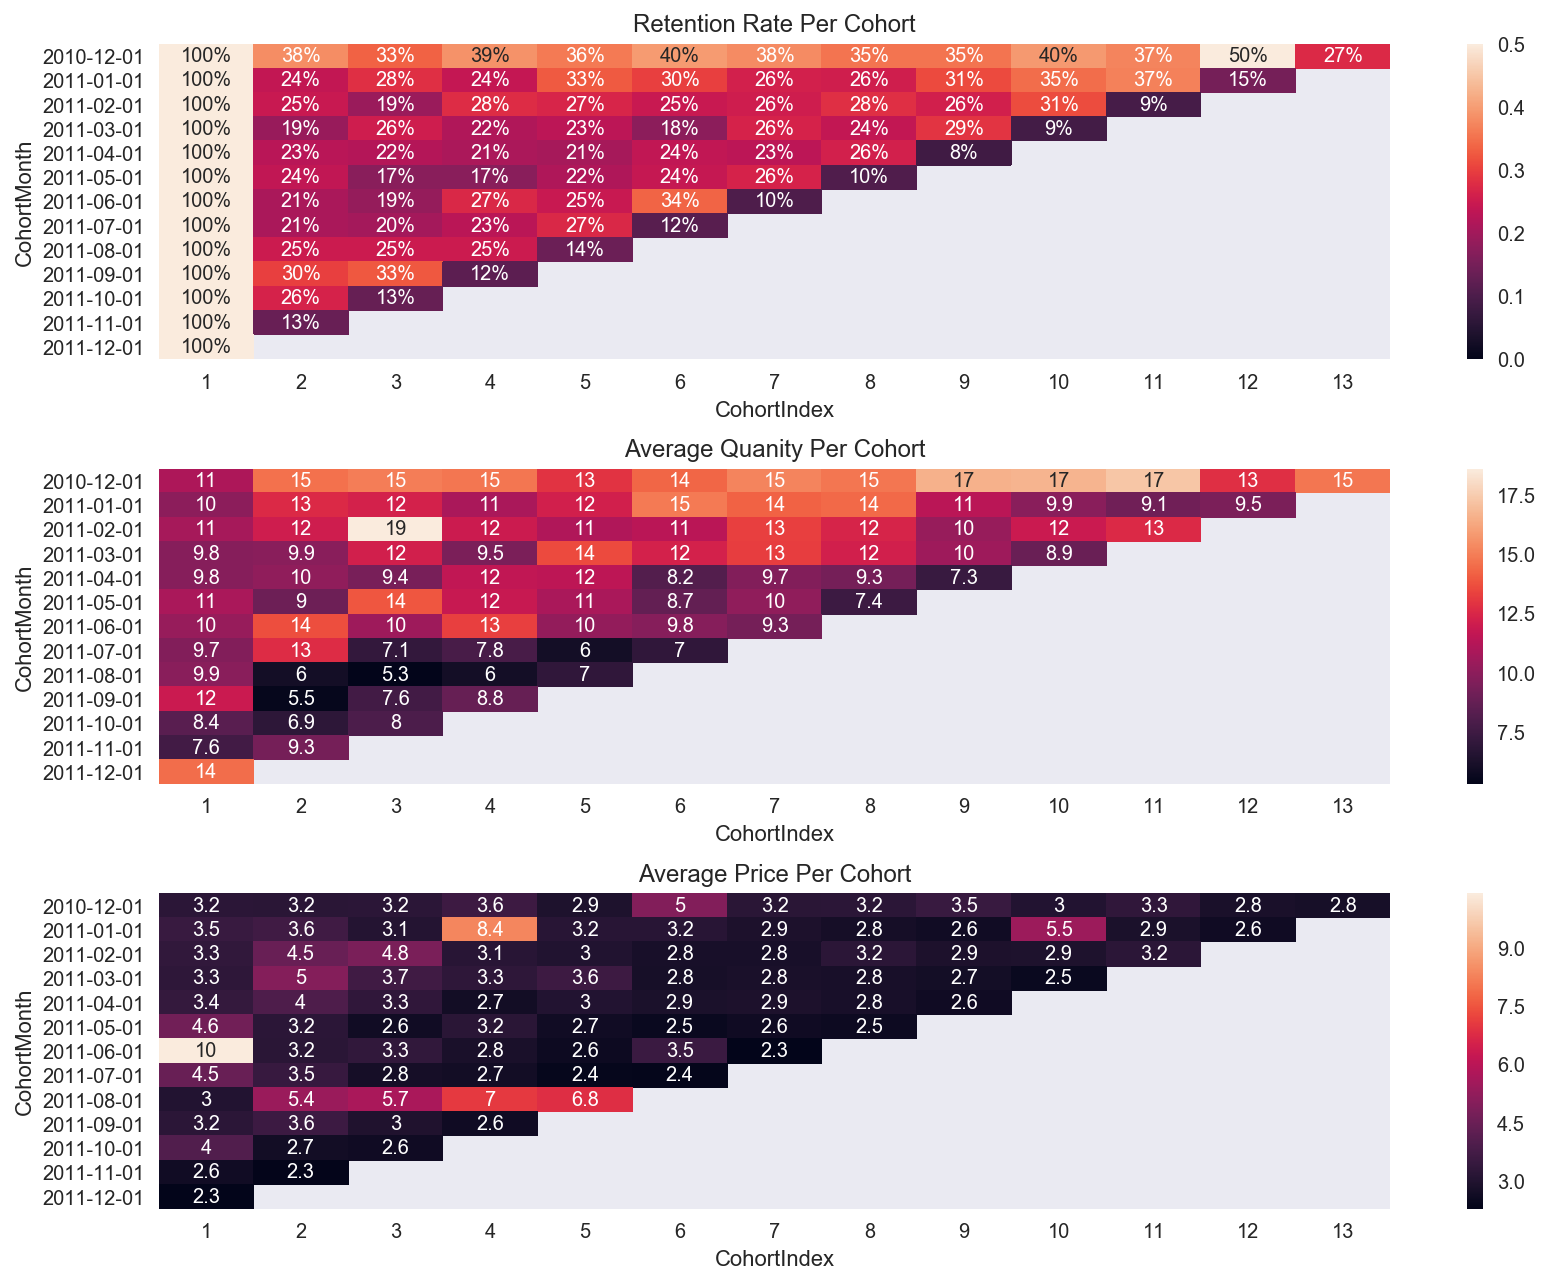

In [42]:
# Plot all 3 graphs together for summary findings
plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)
plt.title('Retention Rate Per Cohort')
ax = sns.heatmap(retention, annot=True, fmt='.0%', vmin=0, vmax=0.5)
ax.set_yticklabels(retention.index.date)

plt.subplot(3, 1, 2)
plt.title('Average Quanity Per Cohort')
ax = sns.heatmap(avg_cohort_quantity, annot=True)
ax.set_yticklabels(avg_cohort_quantity.index.date)

plt.subplot(3, 1, 3)
plt.title('Average Price Per Cohort')
ax = sns.heatmap(avg_cohort_price, annot=True)
ax.set_yticklabels(avg_cohort_price.index.date)

plt.tight_layout()

**Customer retention rate drops over time**
- Customer retention metric measures 2 things:
    1. How many customers are originally in each cohort (acquisition month)
    2. How many of them are still active in the following months
<br><br>
- Approximately 25% of new customers acquired will make a repeat purchase, and this percentage remains fairly consistently barring occasionally increase and dips in activities.


**Quantity of items purchased seems to increase during holiday period**
- The number of items purchased remain fairly constant and increased sharply during the holiday period.

**Bigger purchases are made during holiday period**
- Customers tend to make a bigger purchase during the holiday period; this could be due to a bigger discount/incentive given.

# Recency, Frequency, and Monetary (RFM) Segmentation

RFM is a behavioural customer segmentation for measuring customer value.
- Receny: How recent was each customer's last purchase
- Frequency: How many times the customer purchased in the last 12 months
- Monetary Value: How much has the customer spent in the last 12 months

## Calculating RFM Values

In [43]:
# Calculate 1-year date range from latest data
earliest_date = df['Date'].min()
end_date = df['Date'].max()

print("Actual Start Date: {}, Actual End Date: {}".format(earliest_date, end_date))

# Filter 1-year data range from original df
start_date = end_date - pd.to_timedelta(364, unit='d')
df_rfm = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

print("RFM Start Date: {}, RFM End Date: {}".format(
    df_rfm['Date'].min(), df_rfm['Date'].max()))

Actual Start Date: 2010-12-01, Actual End Date: 2011-12-09
RFM Start Date: 2010-12-10, RFM End Date: 2011-12-09


In [44]:
# Create hypothetical snapshot date
snapshot_date = end_date + dt.timedelta(days=1)

# Calculate Recency, Frequency and Monetary value for each customer
df_rfm = df_rfm.groupby(['CustomerID']).agg({
    'Date': lambda x: (snapshot_date - x.max()).days,
    'Invoice_No': 'count',
    'TotalSum': 'sum'})

# Rename the columns
df_rfm.rename(columns={'Date': 'Recency',
                       'Invoice_No': 'Frequency',
                       'TotalSum': 'MonetaryValue'}, inplace=True)

# Print top 5 rows
print(df_rfm.head())

            Recency  Frequency  MonetaryValue
CustomerID                                   
12346.0         326          2           0.00
12347.0           3        151        3598.21
12348.0          76         31        1797.24
12349.0          19         73        1757.55
12350.0         311         17         334.40


## Building RFM Segments

### Assigning quantile to each customer

In [45]:
# Obtain quantile of each customer
def get_quantile(df, column, start_n_quantiles, end_n_quantiles, step=1):

    category_label = range(start_n_quantiles, end_n_quantiles, step)
    
    quantiles = pd.qcut(df[column], q=abs(
        end_n_quantiles - start_n_quantiles), labels=category_label)

    df = df.assign(name=quantiles.values)

    new_column_name = column + '_Q'

    return df.rename(columns={"name": new_column_name})

In [46]:
df_rfm_quantile = df_rfm.copy()

df_rfm_quantile = get_quantile(df_rfm_quantile, 'Recency', 4, 0, -1)
df_rfm_quantile = get_quantile(df_rfm_quantile, 'Frequency', 1, 5)
df_rfm_quantile = get_quantile(df_rfm_quantile, 'MonetaryValue', 1, 5)

df_rfm_quantile.head()

,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,MonetaryValue_Q
CustomerID,,,,,,
12346.0,326,2,0.00,1,1,1
12347.0,3,151,3598.21,4,4,4
12348.0,76,31,1797.24,2,2,4
12349.0,19,73,1757.55,3,3,4
12350.0,311,17,334.40,1,1,2


### Calculate RFM Score

In [47]:
# Concatenate RFM quartile values
def join_rfm(x): 
    return str(x['Recency_Q']) + str(x['Frequency_Q']) + str(x['MonetaryValue_Q'])

In [48]:
# Form RFM segment
df_rfm_quantile['RFM_Segment'] = df_rfm_quantile.apply(join_rfm, axis=1)

df_rfm_quantile.head()

,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,MonetaryValue_Q,RFM_Segment
CustomerID,,,,,,,
12346.0,326,2,0.00,1,1,1,111
12347.0,3,151,3598.21,4,4,4,444
12348.0,76,31,1797.24,2,2,4,224
12349.0,19,73,1757.55,3,3,4,334
12350.0,311,17,334.40,1,1,2,112


In [49]:
# Calculate RFM_Score
df_rfm_quantile['RFM_Score'] = df_rfm_quantile[['Recency_Q','Frequency_Q','MonetaryValue_Q']].sum(axis=1)

df_rfm_quantile.head()

,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,MonetaryValue_Q,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,2,0.00,1,1,1,111,3.0
12347.0,3,151,3598.21,4,4,4,444,12.0
12348.0,76,31,1797.24,2,2,4,224,8.0
12349.0,19,73,1757.55,3,3,4,334,10.0
12350.0,311,17,334.40,1,1,2,112,4.0


### Analysing RFM Table

In [50]:
df_rfm_quantile.groupby('RFM_Segment').size().sort_values(ascending=False)[:10]

RFM_Segment
444    449
111    391
344    212
122    200
211    174
333    174
222    169
233    157
433    148
311    121
dtype: int64

In [51]:
df_rfm_quantile[df_rfm_quantile['RFM_Segment']=='111'].head()

,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,MonetaryValue_Q,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,2,0.0,1,1,1,111,3.0
12353.0,205,4,89.0,1,1,1,111,3.0
12361.0,288,10,189.9,1,1,1,111,3.0
12386.0,338,2,143.0,1,1,1,111,3.0
12401.0,304,5,84.3,1,1,1,111,3.0


In [52]:
# Summary Metrics per RFM score
df_rfm_quantile.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count'] }).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3.0         247.4       7.9         106.3   391
4.0         163.9      14.0         221.7   375
5.0         146.3      20.7         348.7   507
6.0          87.8      28.4         487.6   460
7.0          80.6      39.4         726.4   436
8.0          57.8      54.8         958.9   464
9.0          44.1      77.4        1351.5   406
10.0         30.6     112.8        1800.2   437
11.0         20.4     197.1        4069.6   370
12.0          6.8     365.0        8612.1   449

### Creating Custom Segments

In [53]:
def segment_me(df):
    if df['RFM_Score'] >= 9:
        return '1.Gold'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9):
        return '2.Silver'
    else:
        return '3.Bronze'

In [54]:
df_rfm_quantile['General_Segment'] = df_rfm_quantile.apply(segment_me, axis=1)

df_rfm_custom_segment = df_rfm_quantile.groupby('General_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)

df_rfm_custom_segment

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
1.Gold             25.2     191.0        4036.1  1662
2.Silver           94.5      35.4         622.8  1867
3.Bronze          206.5      10.8         162.8   766

# Data Pre-Processing for Clustering

K-Means assume symmertical distribution of varibles and variables have equal average value and std.
- If the distribution is not symmetrical
    - Log transformation (if all values are positive)
    - Add the absolute value of the lowest negative value to each observation, and then with a small constant (e.g. 1) to force all variables to be positive
    - Use a cube root transformation
- If the mean and variables are not equal, the variables could be standardised

## Reducing Skewness

In [55]:
def check_skew(df, column):
    skew = stats.skew(df[column])
    skewtest = stats.skewtest(df[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return 

c:\users\sanke\miniconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Recency's: Skew: 1.2444937290057807, : SkewtestResult(statistic=26.458726592189453, pvalue=2.895613835933345e-154)
Frequency's: Skew: 18.12183686440274, : SkewtestResult(statistic=83.17480537059672, pvalue=0.0)
MonetaryValue's: Skew: 21.459150114865714, : SkewtestResult(statistic=86.88030962892341, pvalue=0.0)


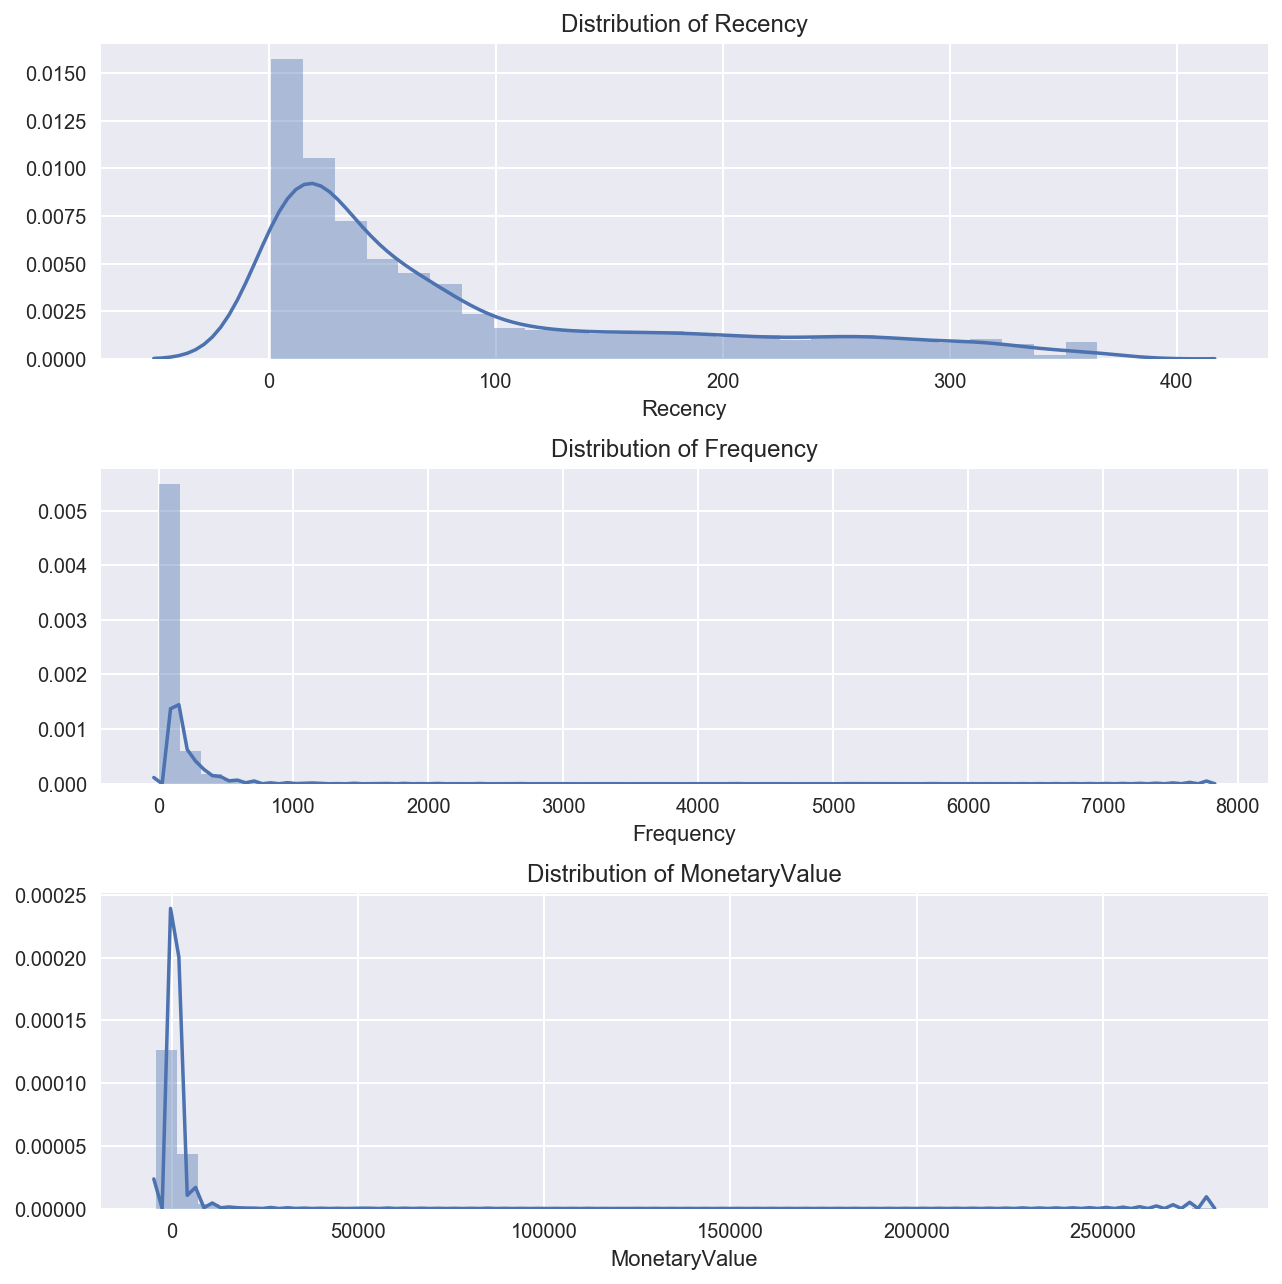

In [56]:
# Plot all 3 graphs together for summary findings
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_rfm,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_rfm,'Frequency')

plt.subplot(3, 1, 3)
check_skew(df_rfm,'MonetaryValue')

plt.tight_layout()
plt.savefig('before_transform.png', format='png', dpi=1000)

In [57]:
df_rfm.describe()

,Recency,Frequency,MonetaryValue
count,4295.000000,4295.000000,4295.000000
mean,87.682654,91.265891,1861.569840
std,94.578749,227.634841,7996.244601
min,1.000000,1.000000,-4287.630000
25%,17.000000,17.000000,290.260000
50%,48.000000,41.000000,644.240000
75%,134.000000,99.000000,1585.915000
max,365.000000,7793.000000,279489.020000


In [58]:
# Copy original to new df
df_rfm_log = df_rfm.copy()

# Data Pre-Processing for Negative Value
df_rfm_log['MonetaryValue'] = (df_rfm_log['MonetaryValue'] - df_rfm_log['MonetaryValue'].min()) + 1

df_rfm_log.describe()

,Recency,Frequency,MonetaryValue
count,4295.000000,4295.000000,4295.000000
mean,87.682654,91.265891,6150.199840
std,94.578749,227.634841,7996.244601
min,1.000000,1.000000,1.000000
25%,17.000000,17.000000,4578.890000
50%,48.000000,41.000000,4932.870000
75%,134.000000,99.000000,5874.545000
max,365.000000,7793.000000,283777.650000


Recency's: Skew: -0.4547480558293254, : SkewtestResult(statistic=-11.634943795553278, pvalue=2.737704076465579e-31)
Frequency's: Skew: -0.239827897754714, : SkewtestResult(statistic=-6.339202735355403, pvalue=2.309571642177164e-10)
MonetaryValue's: Skew: 0.12898570622951602, : SkewtestResult(statistic=3.442875188830196, pvalue=0.0005755648779652933)


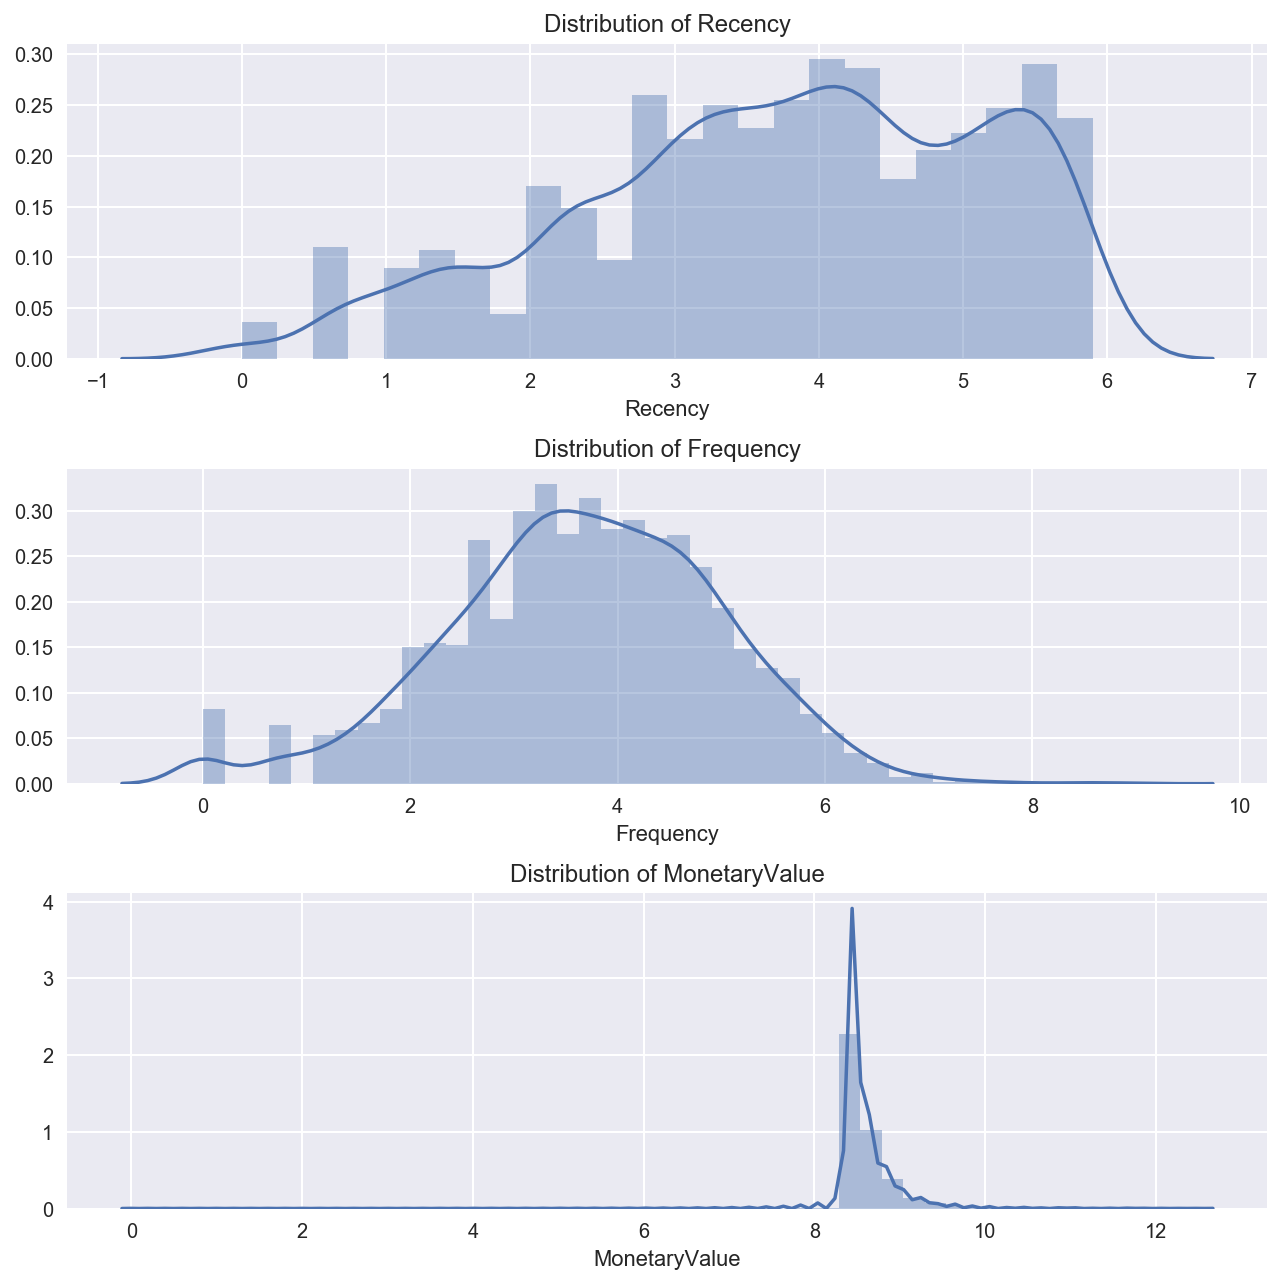

In [59]:
# Transform skewed data with log tranasformation
df_rfm_log = np.log(df_rfm_log)

# Check for skewness after log transformation
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_rfm_log,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_rfm_log,'Frequency')

plt.subplot(3, 1, 3)
check_skew(df_rfm_log,'MonetaryValue')

plt.tight_layout()
plt.savefig('after_transform.png', format='png', dpi=1000)

## Centering and Scaling

In [60]:
# Scaling data
scaler = StandardScaler()
scaler.fit(df_rfm_log)
df_rfm_normal = scaler.transform(df_rfm_log)

df_rfm_normal = pd.DataFrame(df_rfm_normal, index=df_rfm_log.index, columns=df_rfm_log.columns)

# Check result after standardising
df_rfm_normal.describe().round(3)

,Recency,Frequency,MonetaryValue
count,4295.000,4295.000,4295.000
mean,-0.000,-0.000,-0.000
std,1.000,1.000,1.000
min,-2.672,-2.765,-23.890
25%,-0.643,-0.633,-0.511
50%,0.101,0.029,-0.304
75%,0.836,0.692,0.180
max,1.554,3.977,10.935


# K-Means Clustering

## Finding Optimal Number of Clusters

There are two primary methods to define number of clusters:
- Elbow criterion (visual method)
    - Plot number of clusters against within-cluster sum-of-squared-errors (SSE) - sum of squared distances from every data point to their cluster cente
<br><br>
- Silhouette Score (math method)
    - Measures intra- and inter-cluster distance

In [61]:
def optimal_kmeans(dataset, start=2, end=11):
    '''
    Calculate the optimal number of kmeans
    
    INPUT:
        dataset : dataframe. Dataset for k-means to fit
        start : int. Starting range of kmeans to test
        end : int. Ending range of kmeans to test
    OUTPUT:
        Values of Inertia and Silhouette Score.
        Lineplot of values of Inertia and Silhouette Score.
    '''
    
    # Create empty lists to store values for plotting graphs
    n_clu = []
    km_ss = []
    inertia = []

    # Create a for loop to find optimal n_clusters
    for n_clusters in range(start, end):

        # Create cluster labels
        kmeans = KMeans(n_clusters=n_clusters)
        labels = kmeans.fit_predict(dataset)

        # Calcualte model performance
        silhouette_avg = round(silhouette_score(dataset, labels, random_state=1), 3)
        inertia_score = round(kmeans.inertia_, 2)

        # Append score to lists
        km_ss.append(silhouette_avg)
        n_clu.append(n_clusters)
        inertia.append(inertia_score)

        print("No. Clusters: {}, Silhouette Score(SS): {}, SS Delta: {}, Inertia: {}, Inertia Delta: {}".format(
            n_clusters, 
            silhouette_avg, 
            (km_ss[n_clusters - start] - km_ss[n_clusters - start - 1]).round(3), 
            inertia_score, 
            (inertia[n_clusters - start] - inertia[n_clusters - start - 1]).round(3)))

        # Plot graph at the end of loop
        if n_clusters == end - 1:
            plt.figure(figsize=(9,6))

            plt.subplot(2, 1, 1)
            plt.title('Within-Cluster Sum-of-Squares / Inertia')
            sns.pointplot(x=n_clu, y=inertia)

            plt.subplot(2, 1, 2)
            plt.title('Silhouette Score')
            sns.pointplot(x=n_clu, y=km_ss)
            plt.tight_layout()
            plt.show()

No. Clusters: 2, Silhouette Score(SS): 0.395, SS Delta: 0.0, Inertia: 7710.7, Inertia Delta: 0.0
No. Clusters: 3, Silhouette Score(SS): 0.353, SS Delta: -0.042, Inertia: 5971.47, Inertia Delta: -1739.23
No. Clusters: 4, Silhouette Score(SS): 0.288, SS Delta: -0.065, Inertia: 5001.8, Inertia Delta: -969.67
No. Clusters: 5, Silhouette Score(SS): 0.3, SS Delta: 0.012, Inertia: 4203.59, Inertia Delta: -798.21
No. Clusters: 6, Silhouette Score(SS): 0.299, SS Delta: -0.001, Inertia: 3658.91, Inertia Delta: -544.68
No. Clusters: 7, Silhouette Score(SS): 0.305, SS Delta: 0.006, Inertia: 3250.01, Inertia Delta: -408.9
No. Clusters: 8, Silhouette Score(SS): 0.306, SS Delta: 0.001, Inertia: 2704.91, Inertia Delta: -545.1
No. Clusters: 9, Silhouette Score(SS): 0.294, SS Delta: -0.012, Inertia: 2453.03, Inertia Delta: -251.88
No. Clusters: 10, Silhouette Score(SS): 0.296, SS Delta: 0.002, Inertia: 2230.99, Inertia Delta: -222.04


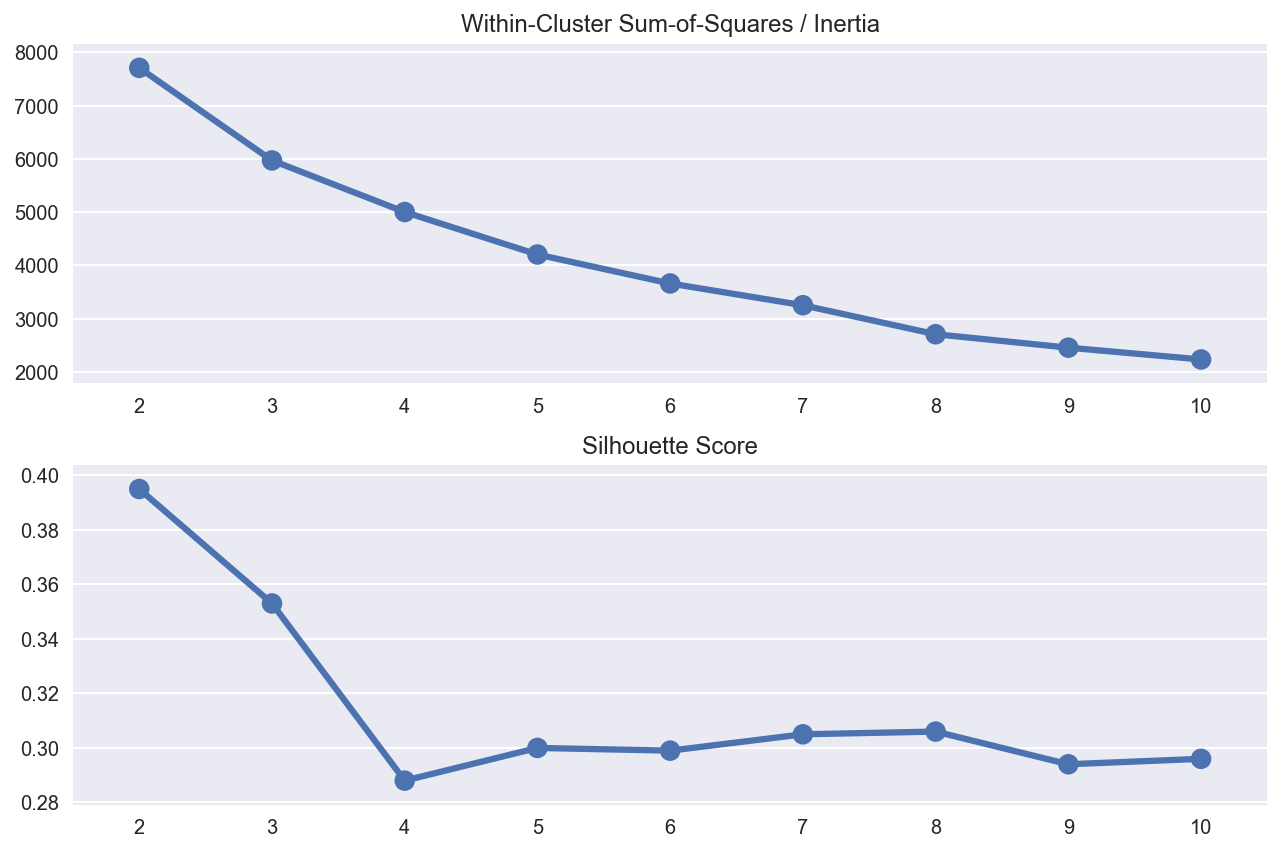

In [62]:
optimal_kmeans(df_rfm_normal)

Based on the inertia and silhouette score, the optimal number of cluster is 4. However, during the implemention of KMEans, cluster of 3, 4, and 5 will be tested to experiment which cluster makes most business sense.

## Implementing KMeans 

In [83]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    '''
    Implement k-means clustering on dataset
    
    INPUT:
        normalised_df_rfm : dataframe. Normalised rfm dataset for k-means to fit.
        clusters_number : int. Number of clusters to form.
        original_df_rfm : dataframe. Original rfm dataset to assign the labels to.
    OUTPUT:
        Cluster results and t-SNE visualisation of clusters.
    '''
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    #plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    #sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

In [84]:
#plt.figure(figsize=(9, 9))

#plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(df_rfm_normal, 3, df_rfm)

#plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(df_rfm_normal, 4, df_rfm)

#plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(df_rfm_normal, 5, df_rfm)

#plt.tight_layout()
#plt.savefig('flattened.png', format='png', dpi=1000)

# Building Customer Personas

## Summary Statistics

In [85]:
def rfm_values(df):
    '''
    Calcualte average RFM values and size for each cluster

    '''
    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'MonetaryValue': ['mean', 'count']
    }).round(0)
    
    return df_new

In [86]:
rfm_values(df_rfm_k3)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          14.0     422.0       11853.0   383
1         153.0      23.0         438.0  2053
2          31.0      99.0        1375.0  1859

In [87]:
rfm_values(df_rfm_k4)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         115.0      57.0         891.0  1525
1          14.0     452.0       13603.0   317
2         160.0      10.0         284.0  1103
3          16.0     112.0        1490.0  1350

In [88]:
rfm_values(df_rfm_k5)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         110.0      65.0         965.0  1365
1          17.0     237.0        3572.0   788
2         175.0      11.0         281.0  1127
3          10.0     768.0       35741.0    80
4          16.0      46.0         735.0   935

## Snake Plots

In [89]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):
    '''
    Transform dataframe and plot snakeplot
    '''
    # Transform df_normal as df and add cluster column
    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=df_rfm.index, 
                                       columns=df_rfm.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'MonetaryValue'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

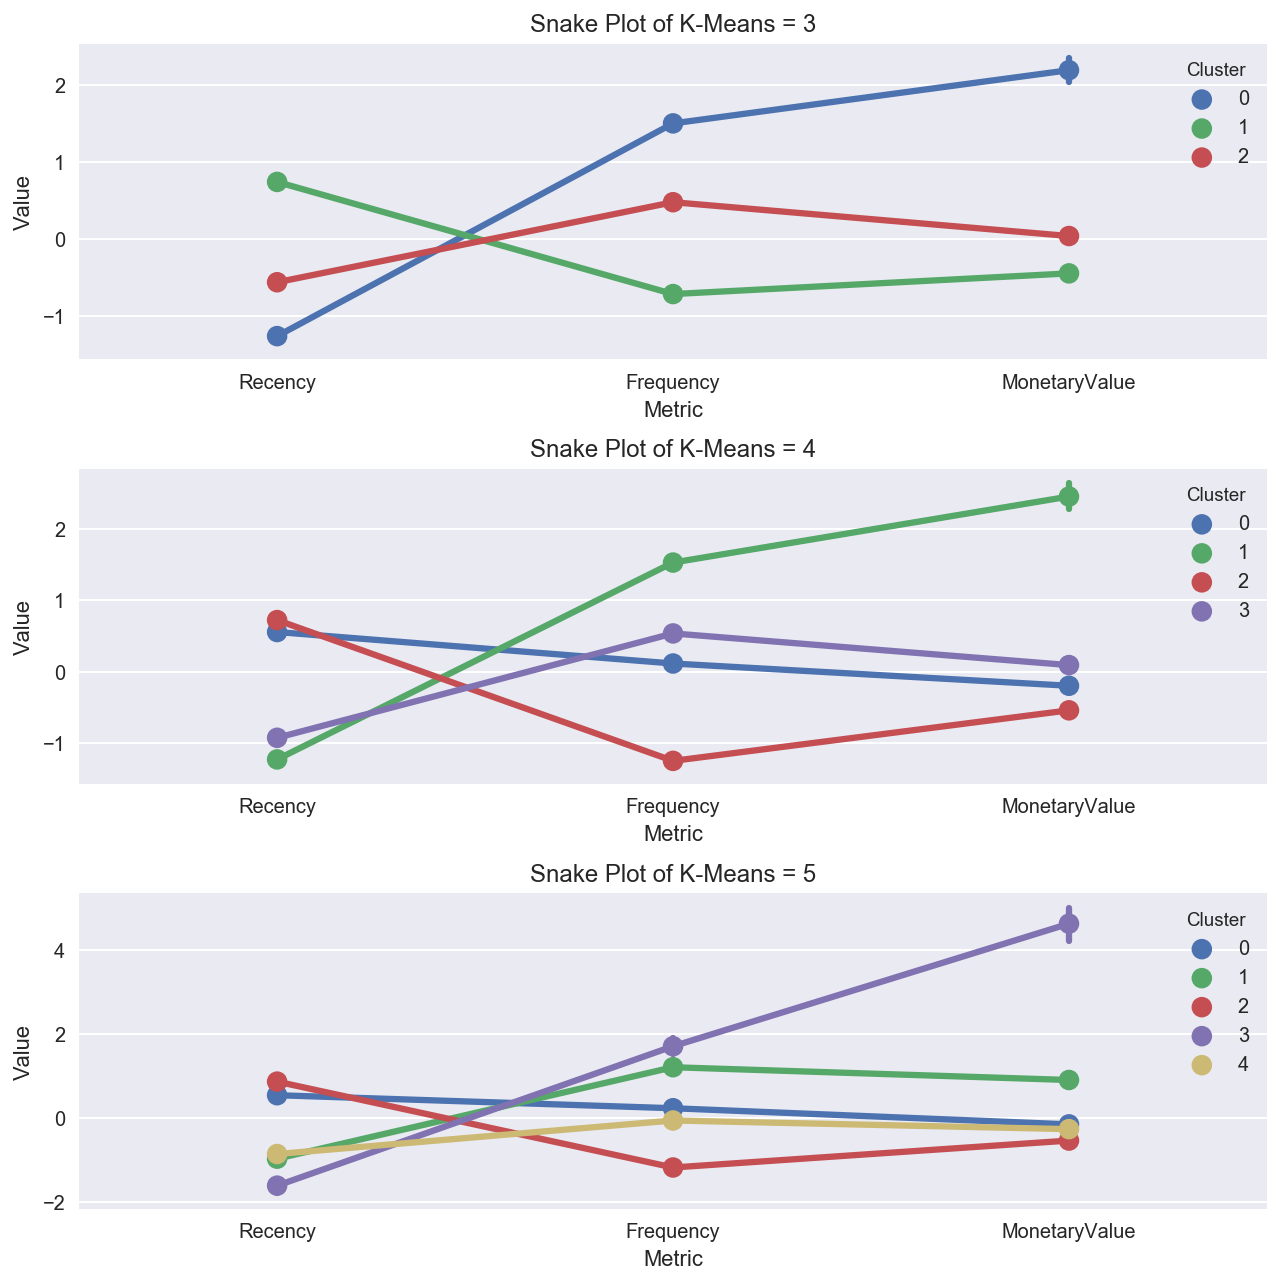

In [90]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 3')
snake_plot(df_rfm_normal, df_rfm_k3, df_rfm)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(df_rfm_normal, df_rfm_k4, df_rfm)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(df_rfm_normal, df_rfm_k5, df_rfm)

plt.tight_layout()

By this stage, each customer in the dataset is tagged with their respective group number. You can proceed to use any industry’s common practices to visualise the results.

Below is an example of using Snake Plot and Relative Importance of Attributes Chart to build personas of each cluster of the segmentation. Both are commonly used in the marketing industry for customer segmentation.

## Relative Importance of Segment Attributes

In [91]:
def relative_importance(df_rfm_kmeans, df_rfm_original):
    '''
    Calculate relative importance of segment attributes and plot heatmap
    '''
    # Calculate average RFM values for each cluster
    cluster_avg = df_rfm_kmeans.groupby(['Cluster']).mean() 

    # Calculate average RFM values for the total customer population
    population_avg = df_rfm.mean()

    # Calculate relative importance of cluster's attribute value compared to population
    relative_imp = cluster_avg / population_avg - 1

    sns.heatmap(data=relative_imp, annot=True, fmt='.2f')
    
    return

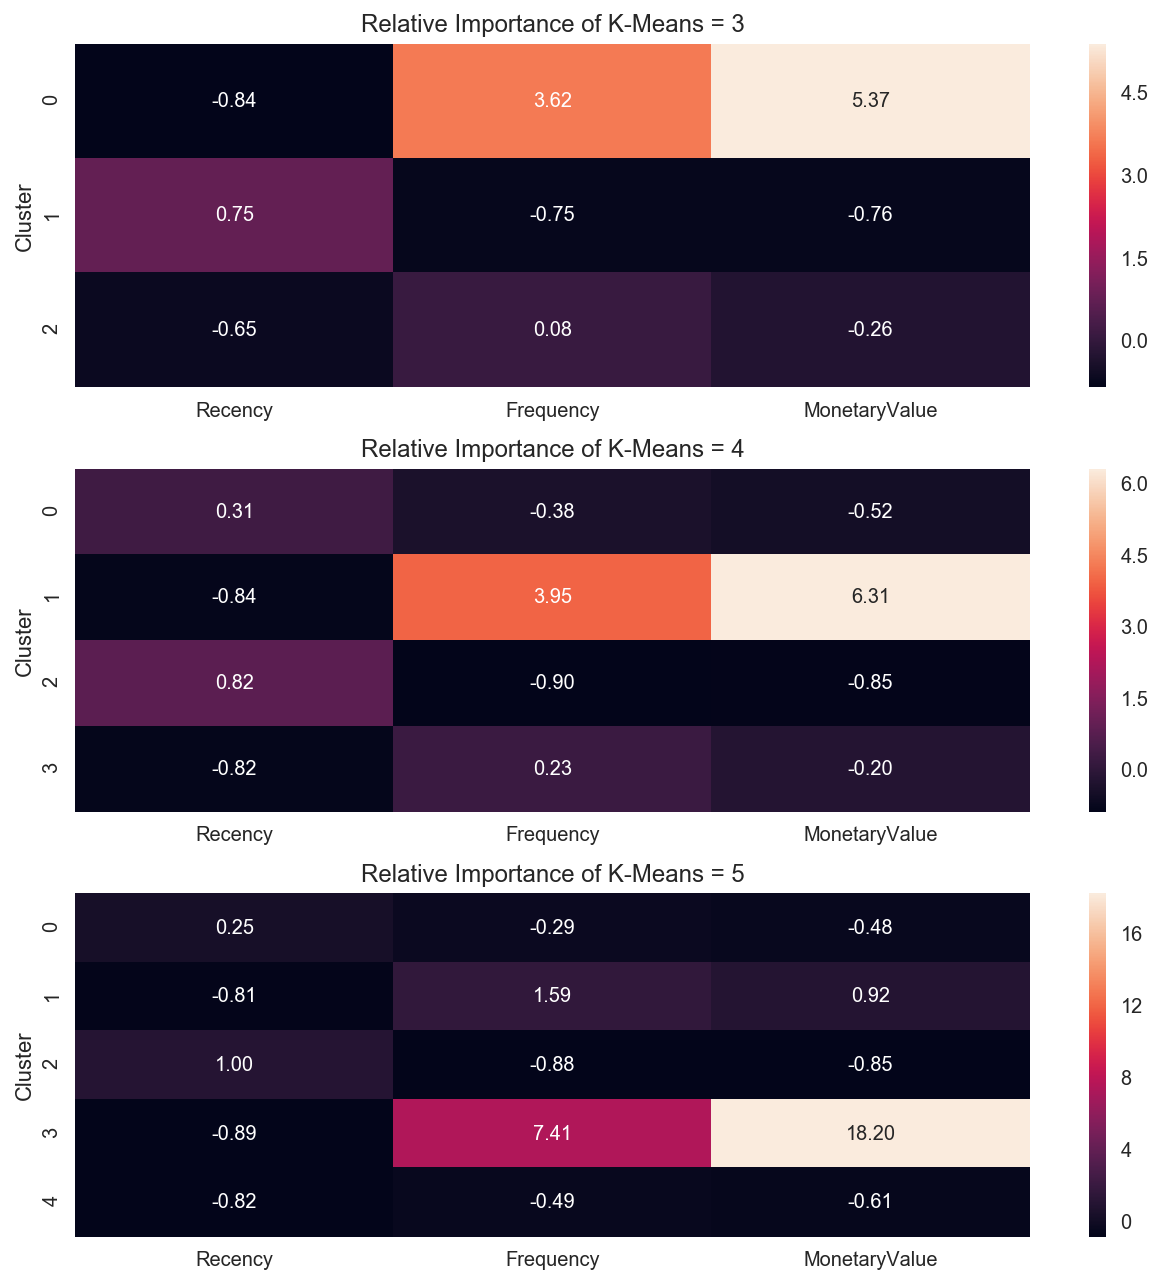

In [92]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Relative Importance of K-Means = 3')
relative_importance(df_rfm_k3, df_rfm)

plt.subplot(3, 1, 2)
plt.title('Relative Importance of K-Means = 4')
relative_importance(df_rfm_k4, df_rfm)

plt.subplot(3, 1, 3)
plt.title('Relative Importance of K-Means = 5')
relative_importance(df_rfm_k5, df_rfm)

plt.tight_layout()

You can take this result and compare it against your original segmentation done using traditional methods. Is there any big difference?

It is a good practice to perform a deep dive and understand why K-means thinks customers of a particular group belong together (yes, sadly K-means is unable to write us a marketing report on their segmentation decision yet).

With this understanding, you could initiate discussion with relevant stakeholders to seek their opinion and get alignment on how to best segment the customers before launching the next big marketing campaign.